# Hello Bluesky: Reading detectors and scanning

In this notebook you will:

* Connect to some simulated hardware.
* Acquire some data via two common experimental procedures ("plans"), ``count`` and ``scan``.
* Write a custom plan.

We will use the following modules---please import them before continuing

In [1]:
import matplotlib
%matplotlib inline
import bluesky
from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
import yaqc_bluesky

Next we need to create an configure a runengine.

In [2]:
RE = RunEngine()
bec = BestEffortCallback()
RE.subscribe(bec)

0

## Configuration

Run the following cell to ensure that all of the yaq daemons are running properly. Everything should be online and not busy.

In [3]:
%%bash
yaqd status

[Errno 111] Connection refused
+-----------+-------+--------------------------+------+---------+-------+
| host      | port  | kind                     | name | status  | busy  |
+-----------+-------+--------------------------+------+---------+-------+
| 127.0.0.1 | 38765 | fake-continuous-hardware | test | offline | ?     |
| 127.0.0.1 | 38100 | fake-continuous-hardware | d1   | online  | False |
| 127.0.0.1 | 38101 | fake-continuous-hardware | d2   | online  | False |
| 127.0.0.1 | 38102 | fake-continuous-hardware | d3   | online  | False |
| 127.0.0.1 | 38200 | fake-triggered-sensor    | pmt  | online  | False |
+-----------+-------+--------------------------+------+---------+-------+


Now, let's generate yaqc-bluesky device objects for each of our daemons.

In [4]:
m1 = yaqc_bluesky.Device(38100)
m2 = yaqc_bluesky.Device(38101)
m3 = yaqc_bluesky.Device(38102)
s1 = yaqc_bluesky.Device(38200)

## Count

In [5]:
from bluesky.plans import count
RE(count([s1]))



Transient Scan ID: 1     Time: 2020-07-16 18:51:29
Persistent Unique Scan ID: '00aa7d29-08ee-41a0-9c3c-c085c68bd04b'
New stream: 'primary'
+-----------+------------+-----------------+
|   seq_num |       time | pmt_random_walk |
+-----------+------------+-----------------+
|         1 | 18:51:29.0 |          -0.180 |
+-----------+------------+-----------------+
generator count ['00aa7d29'] (scan num: 1)





('00aa7d29-08ee-41a0-9c3c-c085c68bd04b',)

## Scan

In [6]:
import matplotlib.pyplot as plt
plt.ion()
from bluesky.utils import install_nb_kicker
install_nb_kicker()
plt.figure('d1_readback vs pmt_random_walk')
plt.gcf()  # Display a snapshot of the current state of the figure.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>



Transient Scan ID: 2     Time: 2020-07-16 18:51:30
Persistent Unique Scan ID: 'a36ba9e2-cd0c-4148-88a2-4afdf8052647'
New stream: 'primary'
+-----------+------------+-------------+-----------------+
|   seq_num |       time | d1_readback | pmt_random_walk |
+-----------+------------+-------------+-----------------+
|         1 | 18:51:31.8 |       0.000 |          -0.087 |
|         2 | 18:51:32.1 |       0.071 |           0.196 |
|         3 | 18:51:32.5 |       0.143 |          -0.025 |
|         4 | 18:51:32.8 |       0.214 |          -0.002 |
|         5 | 18:51:33.1 |       0.286 |           0.099 |
|         6 | 18:51:33.3 |       0.357 |          -0.123 |
|         7 | 18:51:33.6 |       0.429 |          -0.471 |
|         8 | 18:51:34.0 |       0.500 |          -0.111 |
|         9 | 18:51:34.3 |       0.571 |          -0.235 |
|        10 | 18:51:34.6 |       0.643 |          -0.078 |
|        11 | 18:51:34.9 |       0.714 |          -0.264 |
|        12 | 18:51:35.2 |       

Failed to stop <yaqc_bluesky._device.YaqDevice object at 0x7f4a79d93cd0>.
Traceback (most recent call last):
  File "/home/blaise/miniconda3/envs/yaq/lib/python3.8/site-packages/bluesky/run_engine.py", line 1228, in _stop_movable_objects
    stop(success=success)
TypeError: 'NoneType' object is not callable


('a36ba9e2-cd0c-4148-88a2-4afdf8052647',)

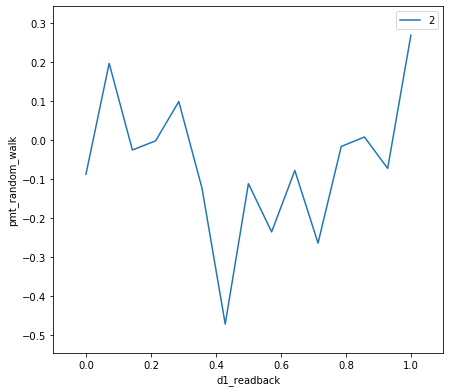

In [7]:
from bluesky.plans import scan
setattr(m1, "tolerance", 1e-6)
RE(scan([s1], m1, 0, 1, 15))

In [34]:
EXPECTED_ATTRS = (
            'name',
            'parent',
            'read',
            'describe',
            'read_configuration',
            'describe_configuration',
            'set',
            'stop',
        )
all(hasattr(m1, a) for a in EXPECTED_ATTRS)

True

In [41]:
from bluesky.utils import Movable
isinstance(m1, Movable)
Movable.register(type(m1))

yaqc_bluesky._device.YaqDevice

In [43]:
from bluesky.plans import grid_scan
setattr(m1, "tolerance", 1e-6)
RE(grid_scan([s1], m1, 0, 1, 15, m2, 0, 1, 15))

Run aborted
Traceback (most recent call last):
  File "/home/blaise/miniconda3/envs/yaq/lib/python3.8/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/home/blaise/miniconda3/envs/yaq/lib/python3.8/site-packages/bluesky/plans.py", line 1157, in grid_scan
    args_pattern = plan_patterns.classify_outer_product_args_pattern(args)
  File "/home/blaise/miniconda3/envs/yaq/lib/python3.8/site-packages/bluesky/plan_patterns.py", line 462, in classify_outer_product_args_pattern
    raise ValueError(f"Incorrect order of elements in the argument list 'args': "
ValueError: Incorrect order of elements in the argument list 'args': some of the movable objects (motors) are out of place (args = [<yaqc_bluesky._device.YaqDevice object at 0x7f4a79d93cd0>, 0, 1, 15, <yaqc_bluesky._device.YaqDevice object at 0x7f4a4a3c6910>, 0, 1, 15])


ValueError: Incorrect order of elements in the argument list 'args': some of the movable objects (motors) are out of place (args = [<yaqc_bluesky._device.YaqDevice object at 0x7f4a79d93cd0>, 0, 1, 15, <yaqc_bluesky._device.YaqDevice object at 0x7f4a4a3c6910>, 0, 1, 15])

Bluesky includes utilities to inspecting plans before they are run. You can imagine various reasons you might want to do this. Example:

In [10]:
from bluesky.simulators import summarize_plan

summarize_plan(scan([s1], m1, -1, 1, 5))

=================================== Open Run ===================================
d1 -> -1.0
  Read ['pmt', 'd1']
d1 -> -0.5
  Read ['pmt', 'd1']
d1 -> 0.0
  Read ['pmt', 'd1']
d1 -> 0.5
  Read ['pmt', 'd1']
d1 -> 1.0
  Read ['pmt', 'd1']
================================== Close Run ===================================


## Custom Plan